In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [101]:
ifd_arr87 = './Assignment_2__Input_FE/inputs_2025_Autumn_PRM/ARR87_IFDs.csv'
catch_area = 2.4

C10_min_contour = 0.6
C10_max_contour = 0.8
C10_mean_contour = 0.7

num_simulations = 10_000_000

zone = 'B' # 'A', 'B', 'C', 'D', 'E', 'F'
elevation = 'Below 500m' # 'Above 500m', 'Below 500m'

print(
    ifd_arr87,
    catch_area,
    C10_min_contour,
    C10_max_contour,
    C10_mean_contour,
    zone,
    elevation,
    sep='\n')

./Assignment_2__Input_FE/inputs_2025_Autumn_PRM/ARR87_IFDs.csv
2.4
0.6
0.8
0.7
B
Below 500m


In [102]:
df_ifd = pd.read_csv(filepath_or_buffer=ifd_arr87, skiprows=2)
df_ifd['duration'] = df_ifd.DURATION.str.split(pat=' ').str[0].astype(int)
df_ifd['units'] = df_ifd.DURATION.str.split(pat=' ').str[1]
df_ifd.units = df_ifd.units.map(arg={'mins':'min', 'hours':'hr', 'hour':'hr'})
df_ifd.duration = df_ifd.apply(func=lambda arg: pd.to_timedelta(arg=arg.duration, unit=arg.units), axis=1)
df_ifd.duration = df_ifd.duration / pd.Timedelta(minutes=1)
df_ifd['duration'] = df_ifd['duration'].astype(int)
df_ifd.drop(columns=['DURATION', 'units'], inplace=True)
df_ifd.set_index(keys='duration', inplace=True)
df_ifd.columns = df_ifd.columns.astype(int)

df_ifd

,1,2,5,10,20,50,100
duration,,,,,,,
5,92.20,118.00,150.00,168.00,192.00,224.00,248.00
6,86.40,111.00,141.00,158.00,181.00,210.00,233.00
10,70.70,90.70,116.00,130.00,149.00,174.00,193.00
20,51.70,66.50,85.60,96.70,111.00,130.00,145.00
30,42.10,54.20,70.10,79.30,91.40,107.00,119.00
60,28.50,36.80,47.90,54.40,62.90,74.10,82.60
120,18.60,24.10,31.50,35.80,41.50,49.00,54.70
180,14.40,18.60,24.40,27.70,32.20,38.00,42.40
360,9.18,11.90,15.60,17.80,20.70,24.50,27.40


In [103]:
tc = 0.76*(catch_area**0.38)
tc = tc*60

tc

63.59824252533506

In [104]:
# Find the insertion point
idx = np.searchsorted(a=df_ifd.index.to_numpy(), v=tc)

# Determine the limits
if idx == 0:
    lower_limit = None
    upper_limit = df_ifd.index.to_numpy()[0]
elif idx == len(df_ifd.index.to_numpy()):
    lower_limit = df_ifd.index.to_numpy()[-1]
    upper_limit = None
else:
    lower_limit = df_ifd.index.to_numpy()[idx - 1]
    upper_limit = df_ifd.index.to_numpy()[idx]

idx = np.array(object=[lower_limit, upper_limit])
idx

array([ 60, 120])

In [105]:
I_minh_Xy = df_ifd.loc[idx.min(),:].to_numpy()
I_maxh_Xy = df_ifd.loc[idx.max(),:].to_numpy()

I_minh_Xy, I_maxh_Xy

(array([28.5, 36.8, 47.9, 54.4, 62.9, 74.1, 82.6]),
 array([18.6, 24.1, 31.5, 35.8, 41.5, 49. , 54.7]))

In [106]:
# I_1h_100y = df_ifd.loc[60,100]
# I_2h_100y = df_ifd.loc[120,100]

# I_1h_100y, I_2h_100y

In [107]:
I_catch = [np.interp(x=tc, xp=[60,120], fp=[ind1, ind2]) for ind1,ind2 in zip(I_minh_Xy, I_maxh_Xy)]
I_catch = np.array(object=I_catch)

I_catch

array([27.90628998, 36.038372  , 46.91648038, 53.28454482, 61.61662683,
       72.59473521, 80.92681723])

In [108]:
# I_catch = np.interp(x=tc, xp=[60,120], fp=[I_1h_100y,I_2h_100y])

# I_catch

In [109]:
# Mean and standard deviation
contours = np.array(object=[C10_min_contour, C10_max_contour])
six_sigma = 2*np.min(a=abs(contours - C10_mean_contour))
std_dev = six_sigma / 6
contours = np.array(object=[C10_mean_contour - 3*std_dev, C10_mean_contour + 3*std_dev])

# Generate random points with a normal distribution
C10_value = np.random.normal(C10_mean_contour, std_dev, num_simulations)

# Filter points to be within the desired range (0.7 to 0.8)
C10_value = C10_value[(C10_value >= contours.min()) & (C10_value <= contours.max())]
C10_value = np.sort(a=C10_value)

C10_value

array([0.60000026, 0.60000123, 0.60000161, ..., 0.79999655, 0.79999864,
       0.79999964])

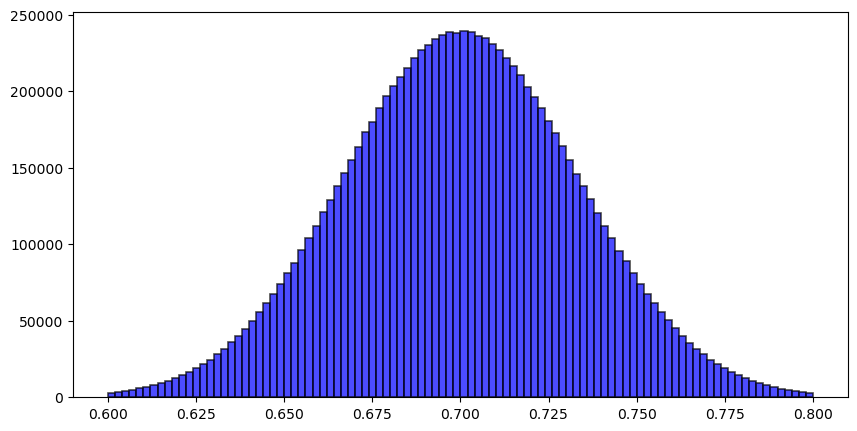

In [110]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(
    x=C10_value,
    bins=100,
    color='blue',
    alpha=0.7,
    edgecolor='black',
    linewidth=1.2
    );

In [111]:
I_12h_50y = df_ifd.loc[720,50]
I_12h_2y = df_ifd.loc[720,2]

I_12h_50y, I_12h_2y

(15.9, 7.69)

In [112]:
constant_50 = 0.366*I_12h_50y/I_12h_2y
constant_100 = 0.588*I_12h_50y/I_12h_2y

constant_50, constant_100

(0.7567490247074121, 1.2157607282184655)

In [113]:
if (zone == 'A') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.67, 'FF_2': 0.81, 'FF_5': 0.92, 'FF_10': 1, 'FF_20': 1.07, 
        'FF_50': 1.90 - constant_50, 
        'FF_100': 2.45 - constant_100,
        }
elif (zone == 'A') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.50, 'FF_2': 0.66, 'FF_5': 0.85, 'FF_10': 1, 'FF_20': 1.14, 
        'FF_50': 1.32, 
        'FF_100': 1.46,
        }
elif (zone == 'B') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.62, 'FF_2': 0.74, 'FF_5': 0.88, 'FF_10': 1, 'FF_20': 1.12, 
        'FF_50': 1.99 - constant_50, 
        'FF_100': 2.57 - constant_100,
        }
elif (zone == 'B') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.57, 'FF_2': 0.70, 'FF_5': 0.86, 'FF_10': 1, 'FF_20': 1.14, 
        'FF_50': 1.33, 
        'FF_100': 1.50,
        }
elif (zone == 'C') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.62, 'FF_2': 0.78, 'FF_5': 0.90, 'FF_10': 1, 'FF_20': 1.10, 
        'FF_50': 1.97 - constant_50, 
        'FF_100': 2.54 - constant_100,
        }
elif (zone == 'C') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.89, 'FF_2': 0.92, 'FF_5': 0.95, 'FF_10': 1, 'FF_20': 1.05, 
        'FF_50': 1.17, 
        'FF_100': 1.24,
        }
elif (zone == 'D') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.43, 'FF_2': 0.58, 'FF_5': 0.80, 'FF_10': 1, 'FF_20': 1.20, 
        'FF_50': 1.54, 
        'FF_100': 1.80,
        }
elif (zone == 'D') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.37, 'FF_2': 0.53, 'FF_5': 0.77, 'FF_10': 1, 'FF_20': 1.25, 
        'FF_50': 1.74, 
        'FF_100': 2.20,
        }
elif (zone == 'E') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.38, 'FF_2': 0.54, 'FF_5': 0.78, 'FF_10': 1, 'FF_20': 1.26, 
        'FF_50': 1.71, 
        'FF_100': 2.14,
        }
elif (zone == 'E') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.52, 'FF_2': 0.64, 'FF_5': 0.82, 'FF_10': 1, 'FF_20': 1.21, 
        'FF_50': 1.52, 
        'FF_100': 1.78,
        }
elif (zone == 'F') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.66, 'FF_2': 0.74, 'FF_5': 0.87, 'FF_10': 1, 'FF_20': 1.15, 
        'FF_50': 1.39, 
        'FF_100': 1.60,
        }
elif (zone == 'F') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.69, 'FF_2': 0.77, 'FF_5': 0.89, 'FF_10': 1, 'FF_20': 1.10, 
        'FF_50': 1.26, 
        'FF_100': 1.34,
        }
else:
    print('Zone and elevation not found')

FF_y

{'FF_1': 0.62,
 'FF_2': 0.74,
 'FF_5': 0.88,
 'FF_10': 1,
 'FF_20': 1.12,
 'FF_50': 1.233250975292588,
 'FF_100': 1.3542392717815344}

In [114]:
# FF_50 = 1.99 - 0.366*I_12h_50y/I_12h_2y
# FF_100 = 2.57 - 0.588*I_12h_50y/I_12h_2y

# FF_50, FF_100

In [115]:
# FF_y = {
#     'FF_1': 0.62, 
#     'FF_2': 0.74, 
#     'FF_5': 0.88, 
#     'FF_10': 1, 
#     'FF_20': 1.12,
#     'FF_50': FF_50,
#     'FF_100': FF_100,
#     }

# FF_y

In [116]:
C100 = np.array(object=[C10_value*ind for ind in np.array(object=list(FF_y.values()))])

C100

array([[0.37200016, 0.37200076, 0.372001  , ..., 0.49599786, 0.49599916,
        0.49599978],
       [0.44400019, 0.44400091, 0.44400119, ..., 0.59199745, 0.59199899,
        0.59199973],
       [0.52800023, 0.52800108, 0.52800142, ..., 0.70399697, 0.7039988 ,
        0.70399968],
       ...,
       [0.67200029, 0.67200137, 0.67200181, ..., 0.89599614, 0.89599848,
        0.8959996 ],
       [0.73995091, 0.7399521 , 0.73995258, ..., 0.98659653, 0.9865991 ,
        0.98660034],
       [0.81254392, 0.81254522, 0.81254575, ..., 1.08338675, 1.08338958,
        1.08339093]])

In [117]:
# C100 = FF_100 * C10_value
# C100

In [118]:
Q_y = C100*np.reshape(a=I_catch, newshape=(7,1))*catch_area/3.6
Q_y = np.transpose(a=Q_y)
Q_y = pd.DataFrame(data=Q_y, columns=df_ifd.columns)

Q_y

,1,2,5,10,20,50,100
0,6.920763,10.667363,16.514608,21.313827,27.604261,35.811027,43.837729
1,6.920774,10.667380,16.514635,21.313861,27.604305,35.811084,43.837799
2,6.920779,10.667387,16.514646,21.313875,27.604323,35.811108,43.837828
3,6.920779,10.667388,16.514648,21.313878,27.604327,35.811112,43.837833
4,6.920780,10.667388,16.514648,21.313879,27.604327,35.811113,43.837834
...,...,...,...,...,...,...,...
9973149,9.227612,14.223040,22.019307,28.418216,36.805395,47.747665,58.449851
9973150,9.227627,14.223063,22.019343,28.418262,36.805456,47.747743,58.449947
9973151,9.227640,14.223083,22.019373,28.418301,36.805507,47.747809,58.450028
9973152,9.227664,14.223120,22.019431,28.418376,36.805603,47.747934,58.450180


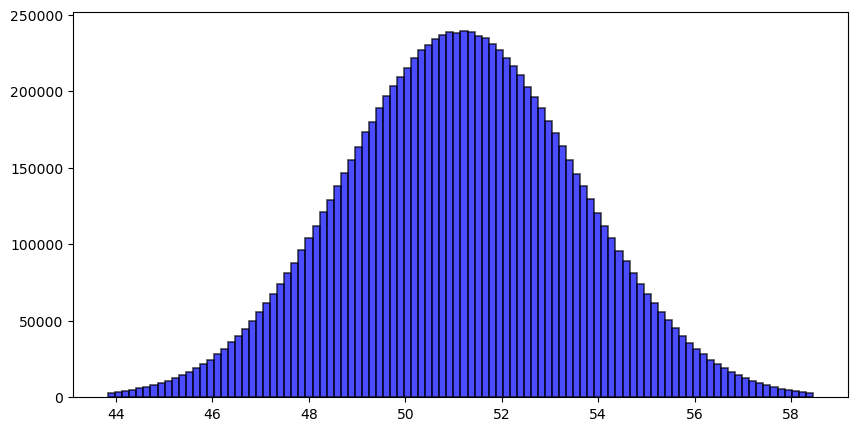

In [119]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(
    x=Q_y[100],
    bins=100,
    color='blue',
    alpha=0.7,
    edgecolor='black',
    linewidth=1.2
    );

In [127]:
Q_y_stats = Q_y.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

Q_y_stats

,1,2,5,10,20,50,100
count,9.973154e+06,9.973154e+06,9.973154e+06,9.973154e+06,9.973154e+06,9.973154e+06,9.973154e+06
mean,8.074314e+00,1.244540e+01,1.926726e+01,2.486641e+01,3.220533e+01,4.178000e+01,5.114459e+01
std,3.792820e-01,5.846088e-01,9.050583e-01,1.168072e+00,1.512810e+00,1.962569e+00,2.402461e+00
min,6.920763e+00,1.066736e+01,1.651461e+01,2.131383e+01,2.760426e+01,3.581103e+01,4.383773e+01
5%,7.446087e+00,1.147707e+01,1.776816e+01,2.293167e+01,2.969958e+01,3.852928e+01,4.716526e+01
25%,7.815773e+00,1.204689e+01,1.865032e+01,2.407018e+01,3.117411e+01,4.044220e+01,4.950693e+01
50%,8.074458e+00,1.244562e+01,1.926760e+01,2.486685e+01,3.220591e+01,4.178075e+01,5.114550e+01
75%,8.332911e+00,1.284399e+01,1.988433e+01,2.566281e+01,3.323677e+01,4.311809e+01,5.278260e+01
95%,8.702107e+00,1.341305e+01,2.076532e+01,2.679982e+01,3.470936e+01,4.502847e+01,5.512118e+01
max,9.227676e+00,1.422314e+01,2.201946e+01,2.841841e+01,3.680565e+01,4.774799e+01,5.845025e+01


In [128]:
print(Q_y_stats.index)

Index(['count', 'mean', 'std', 'min', '5%', '25%', '50%', '75%', '95%', 'max'], dtype='object')


In [129]:
Q_y_plot = Q_y_stats.copy()
Q_y_plot.drop(index=['count', 'std'], inplace=True)

Q_y_plot

,1,2,5,10,20,50,100
mean,8.074314,12.445397,19.267260,24.866412,32.205334,41.780002,51.144593
min,6.920763,10.667363,16.514608,21.313827,27.604261,35.811027,43.837729
5%,7.446087,11.477075,17.768159,22.931665,29.699578,38.529283,47.165256
25%,7.815773,12.046893,18.650319,24.070185,31.174113,40.442199,49.506934
50%,8.074458,12.445618,19.267603,24.866855,32.205907,41.780746,51.145504
75%,8.332911,12.843986,19.884333,25.662809,33.236775,43.118091,52.782602
95%,8.702107,13.413049,20.765324,26.799820,34.709356,45.028472,55.121177
max,9.227676,14.223138,22.019458,28.418411,36.805649,47.747993,58.450253


In [130]:
x = Q_y_stats.columns.to_numpy()
y_mean = Q_y_stats.loc['mean'].to_numpy()
y_05 = Q_y_stats.loc['5%'].to_numpy()
y_25 = Q_y_stats.loc['25%'].to_numpy()
y_50 = Q_y_stats.loc['50%'].to_numpy()
y_75 = Q_y_stats.loc['75%'].to_numpy()
y_95 = Q_y_stats.loc['95%'].to_numpy()
y_min = Q_y_stats.loc['min'].to_numpy()
y_max = Q_y_stats.loc['max'].to_numpy()

x

array([  1,   2,   5,  10,  20,  50, 100])

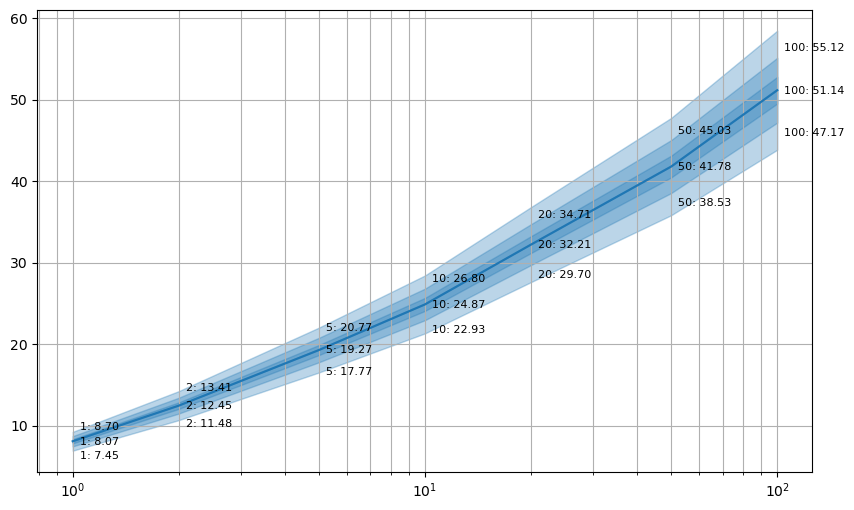

In [143]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y_mean, color='tab:blue', label='Mean', alpha=1)
ax.plot(x, y_50, color='tab:blue', label='Median', alpha=0.3)
ax.fill_between(x=x, y1=y_min, y2=y_max, color='tab:blue', alpha=0.3)
ax.fill_between(x=x, y1=y_05, y2=y_95, color='tab:blue', alpha=0.3)
ax.fill_between(x=x, y1=y_25, y2=y_75, color='tab:blue', alpha=0.3)

for ind1, ind2 in zip(x, y_mean):
    ax.annotate(
        text='{}: {:.2f}'.format(int(ind1), ind2),
        xy=(ind1, ind2),
        xytext=(5, 0),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=8
        )

for ind1, ind2 in zip(x, y_95):
    ax.annotate(
        text='{}: {:.2f}'.format(int(ind1), ind2),
        xy=(ind1, ind2),
        xytext=(5, 7),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=8
        )

for ind1, ind2 in zip(x, y_05):
    ax.annotate(
        text='{}: {:.2f}'.format(int(ind1), ind2),
        xy=(ind1, ind2),
        xytext=(5, -7),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=8
        )

ax.set_xscale(value='log')
ax.grid(which='both', axis='x')#, color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='y')#, color='gray', linestyle='--', alpha=0.5)

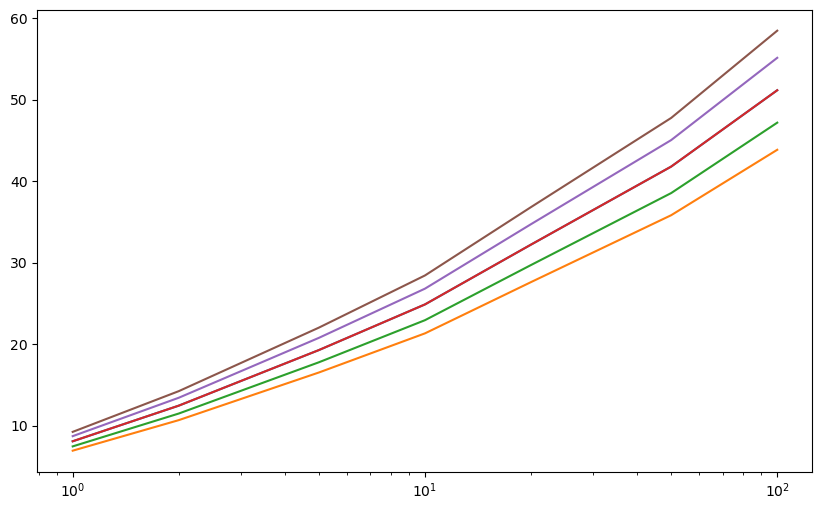

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(Q_y_plot.T, alpha=1)
ax.set_xscale('log')

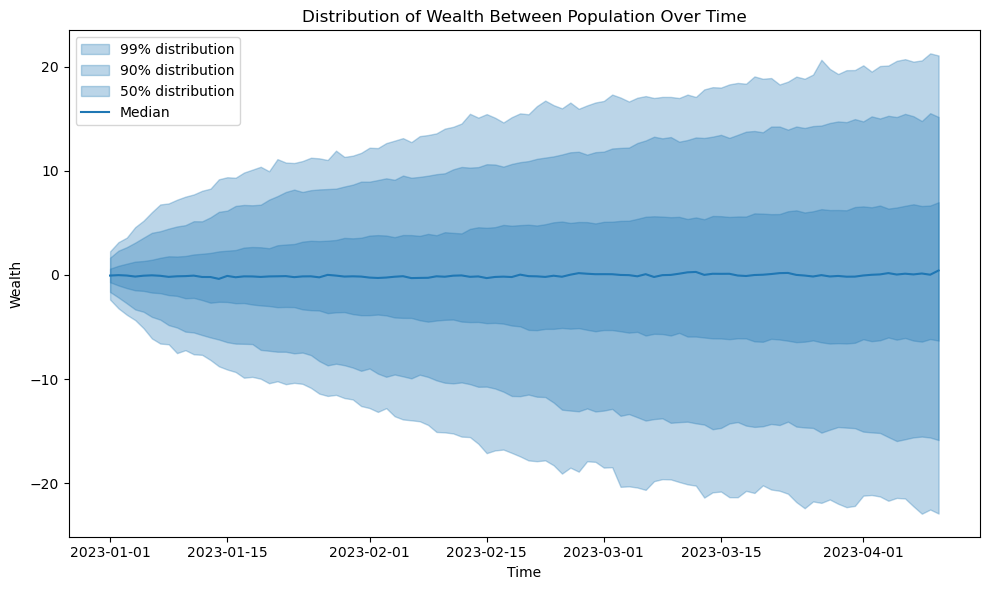

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
dates = pd.date_range('2023-01-01', periods=100)
data = np.random.randn(100, 1000).cumsum(axis=0)

# Calculate percentiles
percentiles = np.percentile(data, [1, 5, 25, 50, 75, 95, 99], axis=1)

# Create a DataFrame for plotting
w_agg = pd.DataFrame({
    'date': dates,
    'q1': percentiles[0],
    'q5': percentiles[1],
    'q25': percentiles[2],
    'q50': percentiles[3],
    'q75': percentiles[4],
    'q95': percentiles[5],
    'q99': percentiles[6]
}).set_index('date')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Add the bands to the axes
ax.fill_between(x=w_agg.index, y1=w_agg["q1"], y2=w_agg["q99"], alpha=0.3, color="tab:blue")
ax.fill_between(x=w_agg.index, y1=w_agg["q5"], y2=w_agg["q95"], alpha=0.3, color="tab:blue")
ax.fill_between(x=w_agg.index, y1=w_agg["q25"], y2=w_agg["q75"], alpha=0.3, color="tab:blue")

# Plot the median as a line
ax.plot(w_agg.index, w_agg["q50"], '-', color="tab:blue")

# Add title, legend, and labels
ax.set_title("Distribution of Wealth Between Population Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Wealth")
ax.legend([f"{n}% distribution" for n in [99, 90, 50]] + ["Median"], loc="upper left")
fig.tight_layout()

# Show the plot
plt.show()

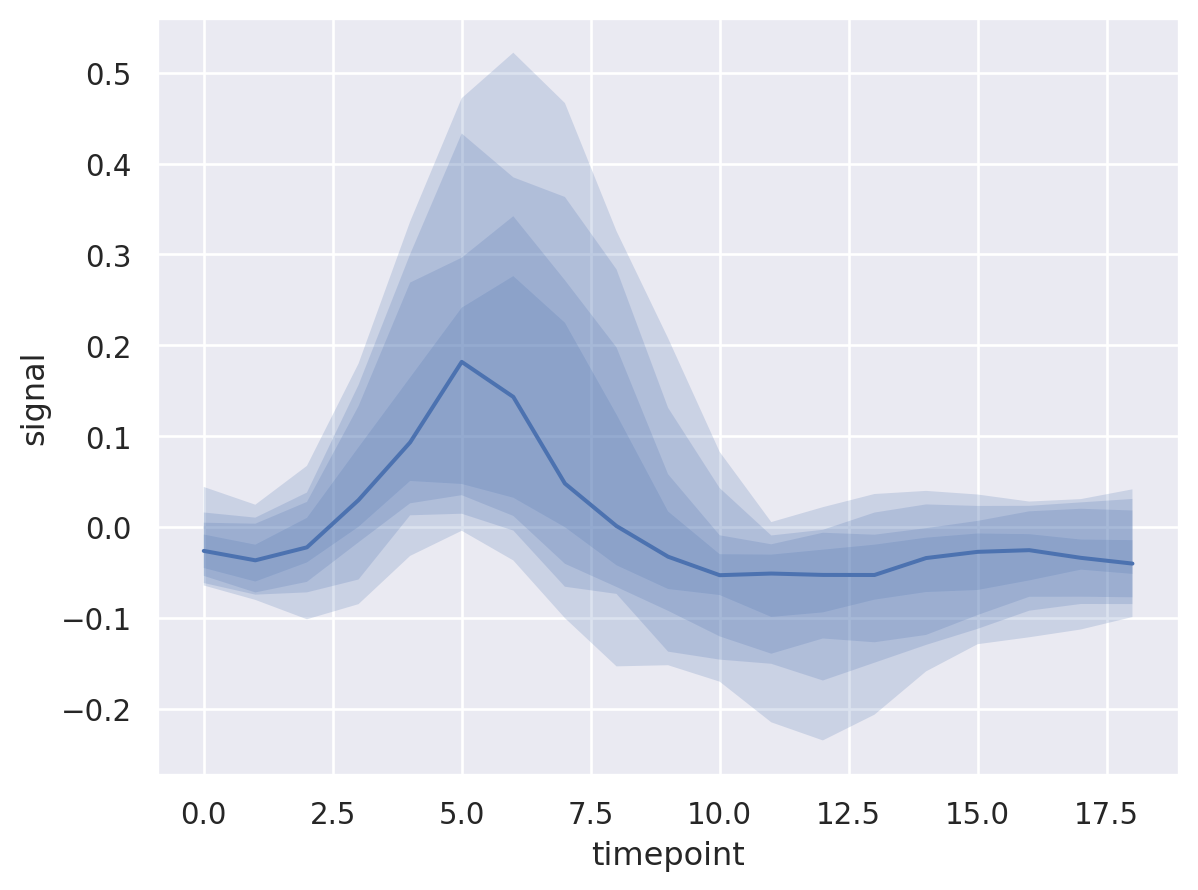

In [136]:
import seaborn as sns
import seaborn.objects as so

fmri = sns.load_dataset("fmri").query("region == 'parietal'")

p = so.Plot(fmri, "timepoint", "signal")
for tail in [25, 10, 5, 1]:
    p = p.add(so.Band(), so.Perc([tail, 100 - tail]))
p.add(so.Line(), so.Agg("median"))